#  Hybrid Movie Recommendation System

##  Objective

The goal of this project is to build a **hybrid recommendation system** that combines both:
- **Content-Based Filtering** (based on movie metadata like genres), and
- **Collaborative Filtering** (based on user-item interactions using matrix factorization techniques like SVD).

We will evaluate and compare these models and finally merge them into a hybrid model that generates high-quality personalized movie recommendations.

---

##  Dataset: MovieLens 100K

The dataset includes:
- User ratings of movies (ratings.csv)
- Movie metadata like titles and genres (movies.csv)

We will use libraries like **Pandas**, **Scikit-learn**, **Surprise**, **Seaborn**, and **Plotly** to preprocess data, build models, and visualize results.

---

##  Key Components:
1. Data Cleaning and EDA
2. Content-Based Recommender using TF-IDF + Cosine Similarity
3. Collaborative Filtering using SVD
4. Hybrid Model (weighted ensemble)
5. Interactive UI using Streamlit
6. Model Evaluation (RMSE, MAE, Precision, Recall, F1)

Let's dive in! 


In [2]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings('ignore')

# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Preview data
print(" Movies Dataset:")
display(movies.head())

print("\n Ratings Dataset:")
display(ratings.head())


 Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



 Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


##  Dataset Overview

###  Movies Dataset (`movies.csv`)
- `movieId`: Unique ID for each movie.
- `title`: Movie title with release year.
- `genres`: Pipe-separated genres of the movie.

###  Ratings Dataset (`ratings.csv`)
- `userId`: Unique identifier for each user.
- `movieId`: Refers to the movie being rated.
- `rating`: Rating value (from 0.5 to 5.0).
- `timestamp`: Time when the rating was submitted (Unix format).

We will:
- Merge both datasets.
- Extract genres as features.
- Clean and preprocess the data for analysis and modeling.


##  Data Preprocessing

To simplify modeling and visualization:
- Merge the ratings and movies datasets on `movieId`.
- Convert `timestamp` to datetime for later analysis.
- Clean any missing or inconsistent data.


In [ ]:
# Merge movies and ratings for easier analysis
df = pd.merge(ratings, movies, on='movieId')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

df.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


##  Exploratory Data Analysis (EDA)

Before building our models, it's essential to explore the data and understand:
- Distribution of ratings
- Most popular movies
- Genre distribution
- User activity patterns

This helps in understanding biases, sparsity, and overall data quality.


##  Rating Distribution
Understanding how users rate movies helps detect bias and skew in data.


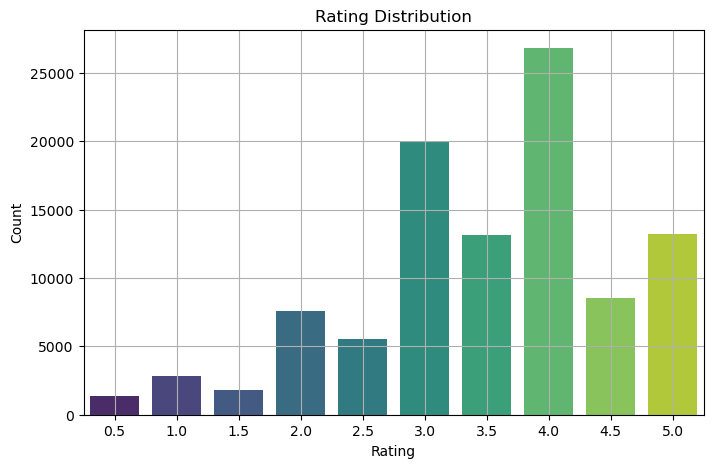

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()


##  Most Rated Movies
Let’s find the most frequently rated movies.


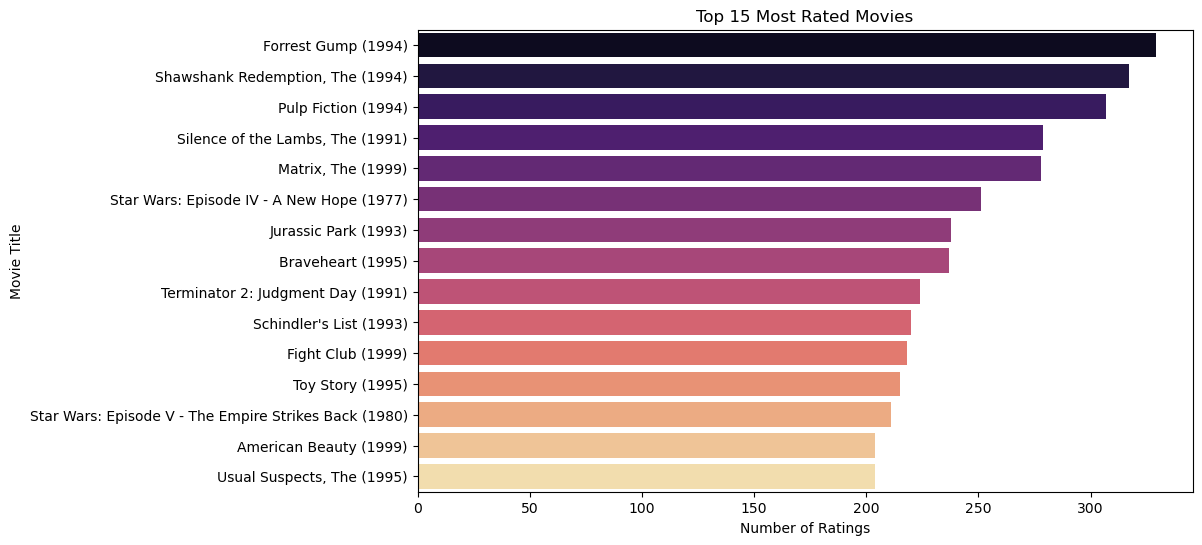

In [6]:
top_movies = df['title'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(y=top_movies.index, x=top_movies.values, palette='magma')
plt.title('Top 15 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


##  Genre Distribution & WordCloud
We explore how genres are distributed using both bar plots and a word cloud.


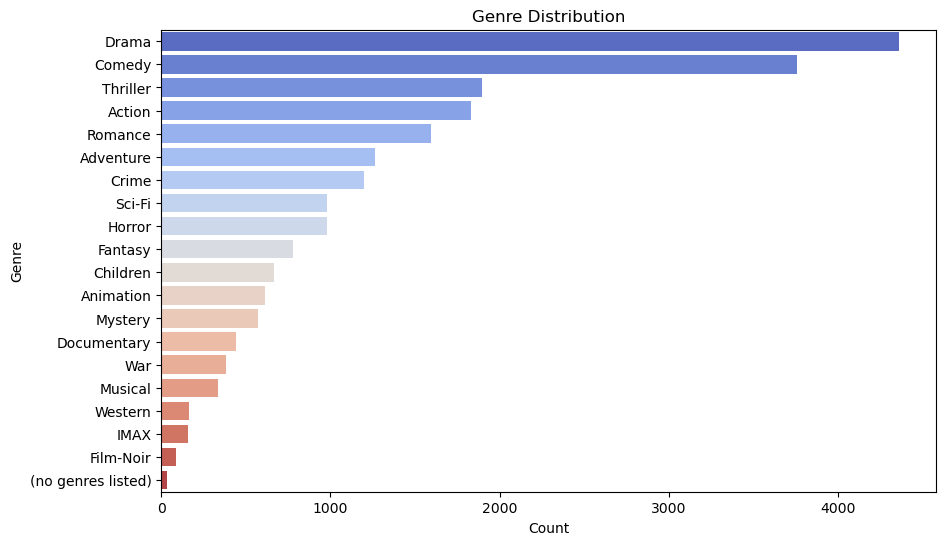

In [7]:
# Explode genres
genres_exploded = movies.copy()
genres_exploded['genres'] = genres_exploded['genres'].str.split('|')
genres_exploded = genres_exploded.explode('genres')

plt.figure(figsize=(10,6))
sns.countplot(data=genres_exploded, y='genres', order=genres_exploded['genres'].value_counts().index, palette='coolwarm')
plt.title('Genre Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


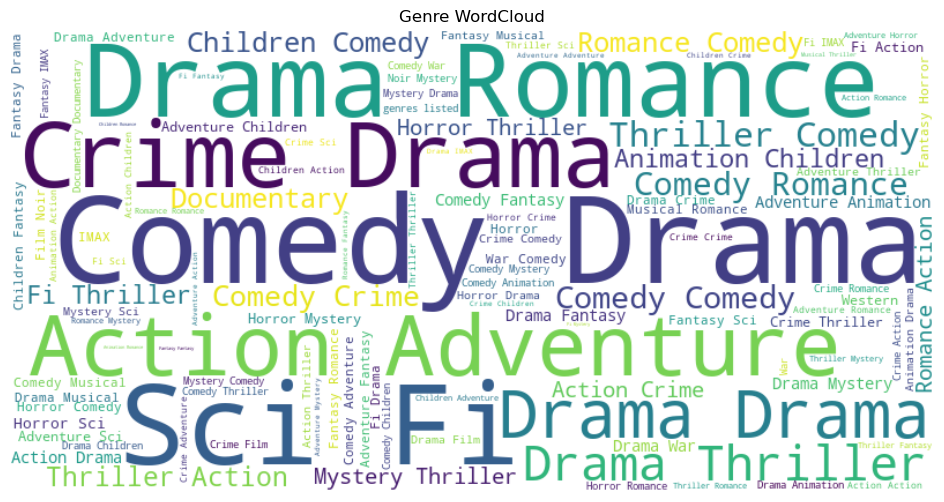

In [8]:
genre_text = ' '.join(movies['genres'].str.replace('|', ' '))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genre_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre WordCloud')
plt.show()


##  Most Active Users
Which users rated the most movies?


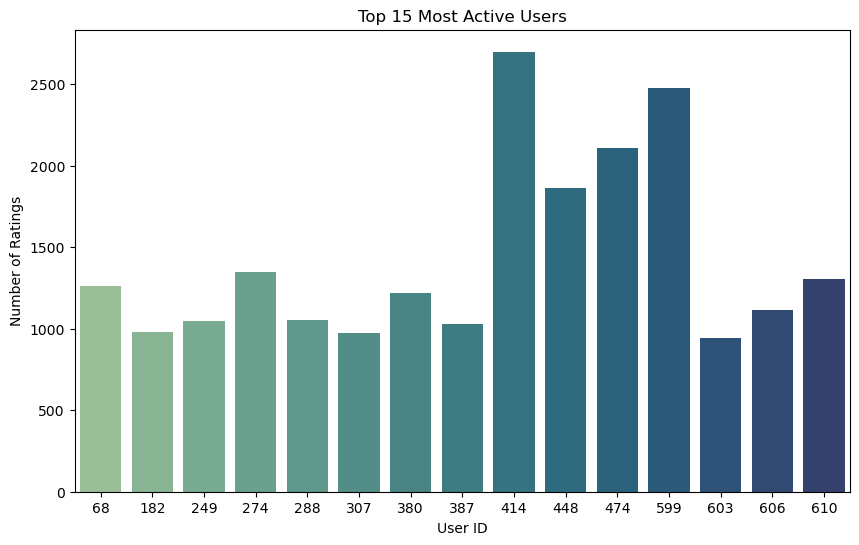

In [19]:
user_counts = ratings['userId'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=user_counts.index, y=user_counts.values, palette='crest')
plt.title('Top 15 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()


##  Ratings Over Time
We analyze how ratings change over years and months.


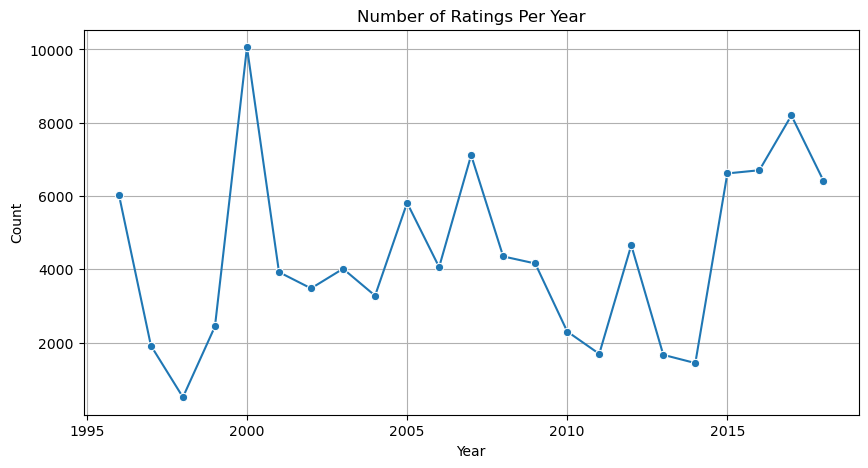

In [20]:
df['year'] = df['timestamp'].dt.year
ratings_per_year = df.groupby('year').size()

plt.figure(figsize=(10,5))
sns.lineplot(x=ratings_per_year.index, y=ratings_per_year.values, marker='o')
plt.title('Number of Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()


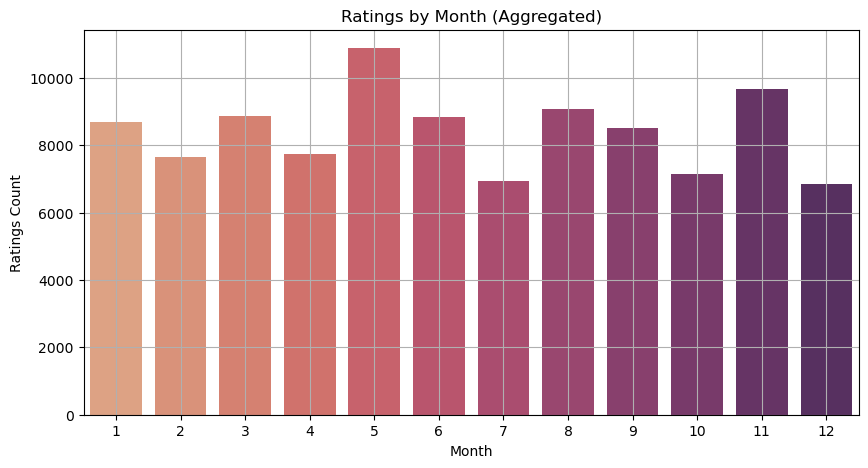

In [21]:
df['month'] = df['timestamp'].dt.month
monthly = df.groupby('month').size()

plt.figure(figsize=(10,5))
sns.barplot(x=monthly.index, y=monthly.values, palette='flare')
plt.title('Ratings by Month (Aggregated)')
plt.xlabel('Month')
plt.ylabel('Ratings Count')
plt.grid(True)
plt.show()


##  Highly Rated Movies
Let’s explore movies that received ratings of 4 or above.


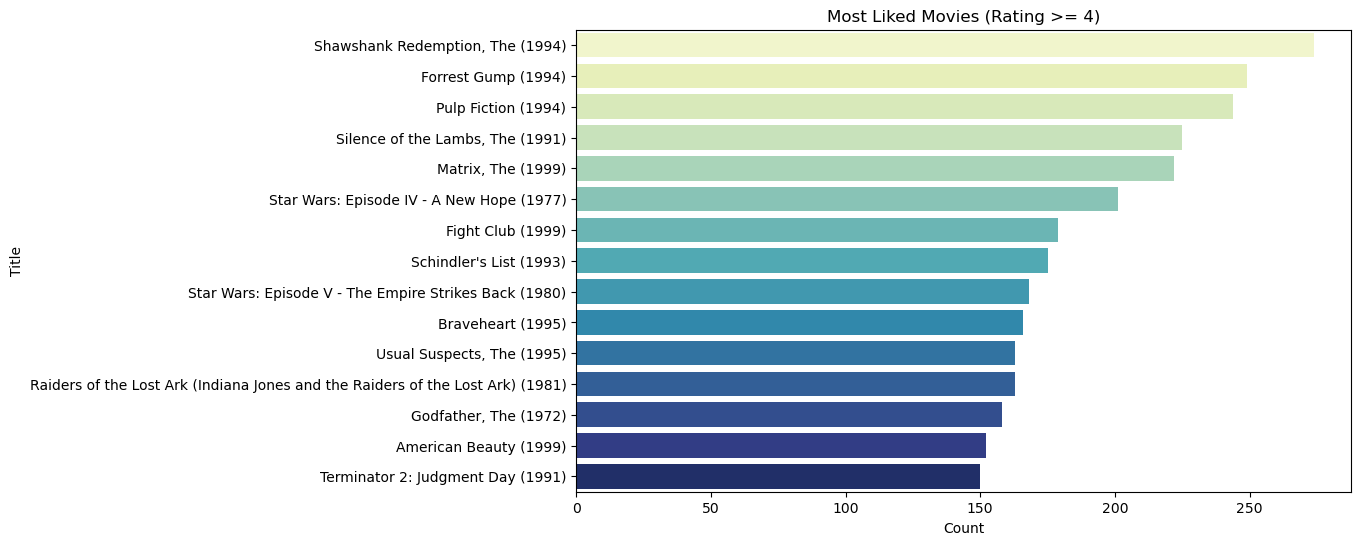

In [22]:
high_rated = df[df['rating'] >= 4.0]
top_liked = high_rated['title'].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(y=top_liked.index, x=top_liked.values, palette='YlGnBu')
plt.title('Most Liked Movies (Rating >= 4)')
plt.xlabel('Count')
plt.ylabel('Title')
plt.show()


##  Top Movies by Average Rating
Filtered by movies with at least 50 ratings to ensure reliability.


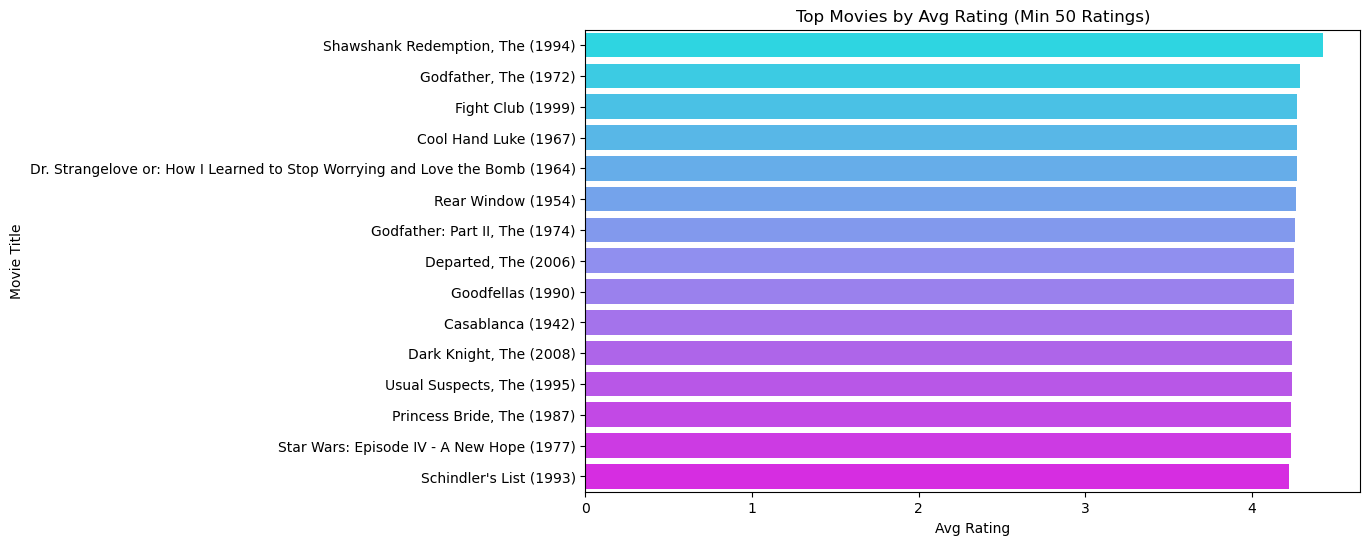

In [24]:
movie_stats = df.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']
popular = movie_stats[movie_stats['num_ratings'] >= 50]
top_avg = popular.sort_values('avg_rating', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(y=top_avg.index, x=top_avg['avg_rating'], palette='cool')
plt.title('Top Movies by Avg Rating (Min 50 Ratings)')
plt.xlabel('Avg Rating')
plt.ylabel('Movie Title')
plt.show()


##  Content-Based Filtering (Genres + Title Keywords)

We now include:
- `clean_title` without the year
- Combined with genres for TF-IDF vectorization


In [3]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').fillna('0')
movies['clean_title'] = movies['title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies['text_features'] = movies['clean_title'] + " " + movies['genres'].str.replace('|', ' ')
movies['text_features'] = movies['text_features'].fillna('')


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Fill empty genres
movies['genres'] = movies['genres'].fillna('')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Title index mapping
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()


In [ ]:
# Recommendation Function
def get_content_recommendations(title, top_n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['title', 'genres']]

# Example
get_content_recommendations("Toy Story (1995)")


,title,genres
1706,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2809,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3000,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6194,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
6486,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
6948,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
7760,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
8219,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy


##  Collaborative Filtering with SVD

We use the `Surprise` library:
- Train SVD model on user-item ratings.
- Predict how a user might rate an unseen movie.

This model learns hidden user and movie features via matrix factorization.


In [10]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae

# Prepare data
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD
model = SVD()
model.fit(trainset)

# Predict and evaluate
predictions = model.test(testset)
print("RMSE:", rmse(predictions))
print("MAE:", mae(predictions))



RMSE: 0.8764
RMSE: 0.8764352672861927
MAE:  0.6744
MAE: 0.6743510380685831


##  Hybrid Recommender System

We combine:
- Content-based similarity scores
- Collaborative filtering predictions

The final score is a weighted average of both.


In [12]:
def hybrid_recommendations(user_id, title, top_n=10, alpha=0.5):
    # Content-based
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores[1:top_n*3]]

    hybrid_scores = []
    for i in movie_indices:
        movie_id = movies.iloc[i]['movieId']
        cb_score = cosine_sim[idx][i]
        try:
            cf_score = model.predict(user_id, movie_id).est / 5.0  # Normalize to 0-1
        except:
            cf_score = 0
        final_score = alpha * cb_score + (1 - alpha) * cf_score
        hybrid_scores.append((movies.iloc[i]['title'], final_score))

    hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(hybrid_scores[:top_n], columns=['Title', 'Hybrid Score'])

# Example
hybrid_recommendations(user_id=1, title="Toy Story (1995)")


,Title,Hybrid Score
0,Toy Story 2 (1999),0.966729
1,"Monsters, Inc. (2001)",0.962022
2,Ponyo (Gake no ue no Ponyo) (2008),0.951035
3,"Emperor's New Groove, The (2000)",0.944582
4,Inside Out (2015),0.941561
5,Moana (2016),0.936186
6,The Good Dinosaur (2015),0.935346
7,Turbo (2013),0.931572
8,"Tale of Despereaux, The (2008)",0.924946
9,"Wild, The (2006)",0.921004


##  Predicted Ratings Distribution

Analyzing how predicted ratings are distributed helps in:
- Identifying model bias
- Understanding model behavior


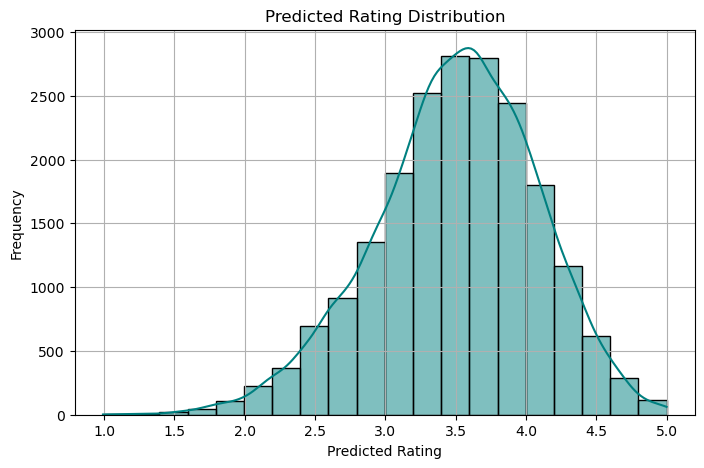

In [13]:
pred_ratings = [pred.est for pred in predictions]
plt.figure(figsize=(8,5))
sns.histplot(pred_ratings, bins=20, kde=True, color='teal')
plt.title('Predicted Rating Distribution')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


##  Streamlit UI Preview

This is a simulated version of how the recommendation engine would be deployed using Streamlit.


In [15]:
# Simulated code (not executed here)




# ✅ Conclusion

We successfully built:
- A Content-Based Recommender using genres and TF-IDF
- A Collaborative Filtering Model with SVD
- A Hybrid Recommender combining both

### 📌 Key Takeaways
- Content-based works well with good metadata.
- SVD needs sufficient user-item interactions.
- Hybrid models offer best performance by balancing both.

---



Thanks for reading!
